# Financial Data Structures: Standard Bars

我在阅读 **Advances in Financial Machine Learning** 期间会结合研究 **mlfinlab** 库去写一些notebook来记录我的学习过程，这是第一篇，大部分notebook会换成中国期货市场数据。

该系列notebook中提到的"本书"或者"书"就是指的 **Advances in Financial Machine Learning**

在书中提到的一些代码我不再重新编写，我用到了 [mlfinlab](https://github.com/hudson-and-thames/mlfinlab) 库  ，这大大节省了我的工作量。然后结合 [mlfinlab research](https://github.com/hudson-and-thames/research) 中的分析文章，也加快了我对该书内容的理解，非常感谢。

我在这个系列的文章中，大部分是直接用 [mlfinlab research](https://github.com/hudson-and-thames/research) 中的分析文章，只是会用中国期货市场数据，有些会加一些自己的想法。

***

While I'm reading **Advances in Financial Machine Learning**, I'll write some notebooks to document my learning process in conjunction with **mlfinlab** library. This is the first. And most of the notebooks will be replaced with Chinese futures market data.

The **"Book"** mentioned in the series of notebook is referred to **Advances in Financial Machine Learning**

I'm not getting ready to rewrite the code mentioned in the book. And I've used the library [mlfinlab](https://github.com/hudson-and-thames/mlfinlab), which saves me a lot of work. Then, combined with the analytical articles in [mlfinlab](https://github.com/hudson-and-thames/research), i'm also speeding up my understanding of the content of the book, tks to them.

Most of my articles in this series are directly copied from [mlfinlab research](https://github.com/hudson-and-thames/research), and will use Chinese futures market data, some of which will add some of my own ideas.


**这个notebook主要对比一下传统的time bars和书中提到的各种 Standard Bars 进行一下比较**
***
**This notebook compares the traditional time bars with the various Standard Bars mentioned in the book**

In [14]:
import mlfinlab as ml
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from statsmodels.tsa import stattools as ts
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt


In [25]:
TICK_FILE_PATH = 'data/rb_1year_tick.csv'

def get_data_df():
    df = pd.read_csv(TICK_FILE_PATH)
    df['date_time'] = pd.to_datetime(df['date_time'])
    df.set_index('date_time', inplace=True)
    return df

def generate_time_bars():
    df = get_data_df()
    return df['price'].resample('5min').ohlc().dropna()

Generating time bars


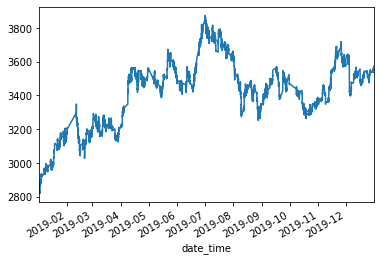

In [28]:
print("Generating time bars")
time_bars = generate_time_bars()

time_bars['close'].plot()

---
## 用mlfinlab生成Standard Bars（Use mlfinlab: Create Data Structures）

我的测试数据选取了中国上海期货交易所的一支流动性很好的品种：螺纹钢(RB) 20190101~20200101 前复权主连数据

由于中国期货市场的快照类型tick数据和美国市场的逐笔tick数据不一样，所以我新增了一些函数

主要有 **Volume Bars**, **Dollar Bars**, **Tick Bars**

简单来讲就是每根 bar 有接近一样的Volume,Dollar,Tick counts。 

- 为什么是接近一样？因为每根bar的Volume和Dollar很难达到完全相等。

- Dollar在中国期货数据中叫Amount，是已有字段，不需要向书中说的用price乘以volume。

- 然后由于中国期货tick数据是快照，每秒两次，是固定数量，所以Tick Bars和Time Bars应该是一样的，这点可以在后面的分析中看出。

下面我们来生成书中提到的各种 Standard Bars，information driven bars这里就不涉及。
***
My test data selected a very liquid instrument of China Shanghai Futures Exchange: Rebar (RB) 20190101-2020001 split-adjusted share prices Continues Contract Data

Since the snapshot type tick data in the Chinese futures market is different from the one-tick data in the U.S. market, So I added some functions

The Standard Bars in the book: **Volume Bars**, **Dollar Bars**, **Tick Bars**

Simply put, each bar has close to the same Volume, Dollar or Tick counts. 

- Why is it close to the same? Because it's hard to get full equal for Volume and Dollar for each bar.

- Dollar is called Amount in China Futures Data, which is an existing field and does not need to be price-multiplied by volume in the book.

- Then since the Chinese futures tick data is a snapshot, twice per second, a fixed number, tick Bars and Time Bars should be the same, as can be seen in the subsequent analysis.

Next we create the various data structures. In this example we focus on the standard bar types but the information driven bars are also available.



In [16]:
print("Generating dollar bars")
dollar_bars = ml.data_structures_snapshot_tick.get_dollar_bars(TICK_FILE_PATH, threshold=1000000000, 
                                                               batch_size=1000000, verbose=True)

print("Generating volume bars")
volume_bars = ml.data_structures_snapshot_tick.get_volume_bars(TICK_FILE_PATH, threshold=28000, 
                                                               batch_size=1000000, verbose=False)

print("Generating tick bars")
tick_bars = ml.data_structures_snapshot_tick.get_tick_bars(TICK_FILE_PATH, threshold=400, 
                                                           batch_size=1000000, verbose=False)

Generating time bars
Generating dollar bars
Reading data in batches:
Batch number: 0
Batch number: 1
Batch number: 2
Batch number: 3
Batch number: 4
Batch number: 5
Batch number: 6
Batch number: 7
Batch number: 8
Batch number: 9
Returning bars 

Generating volume bars
Generating tick bars


In [ ]:
# 把日期设置为索引
# set date_time to index
dollar_bars.set_index("date_time", inplace=True)
volume_bars.set_index("date_time", inplace=True)
tick_bars.set_index("date_time", inplace=True)

---
## 分析一些统计性质 (Analyze Statistical Properties)

现在我们去分析一下不同种类 bars 的统计性质

Now we turn to analyze the statistical properties of the new data structures.

### 测量稳定性 (Measure Stability)

这里说的稳定性主要是指固定周期内的bar的数量是否稳定

if quantities of the bars during the fixed period is stable

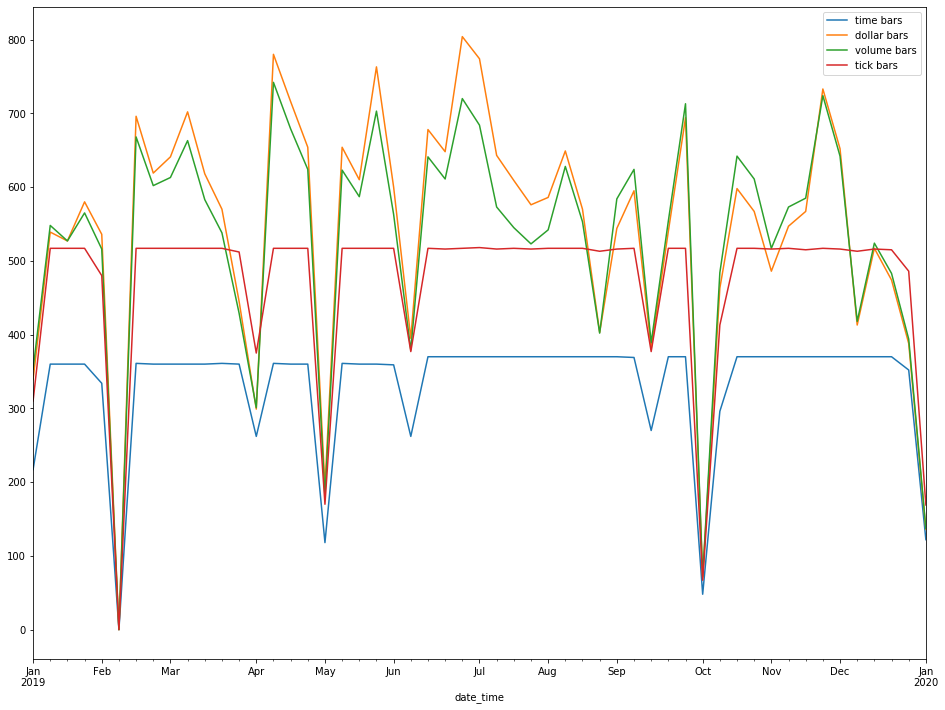

In [18]:
time_count = time_bars['close'].resample('W', label='right').count()
dollar_count = dollar_bars['close'].resample('W', label='right').count()
volume_count = volume_bars['close'].resample('W', label='right').count()
tick_count = tick_bars['close'].resample('W', label='right').count()

plt.figure(figsize=(16,12))

time_count.plot(label='time bars')
dollar_count.plot(label='dollar bars')
volume_count.plot(label='volume bars')
tick_count.plot(label='tick bars')

plt.legend()
plt.show()

图中tick bars和time bars往下的凹陷是因为某个星期有节假日的关系，2月份以后是因为疫情原因取消了夜盘，我们把这些异常值过滤掉

下个代码块中的 time_count>300 中的 300 是我根据上图，人肉设置的一个值，为了过滤一些因为节假日导致的异常值
***
The dent in the tick bars and time bars is due to a week of holidays, and after February the night plate was cancelled because of the outbreak, and we filtered out these anomalies

The 300 in the **time_count>300** in the next block of code is a value derived from the figure above, in order to filter out some outliers caused by holidays

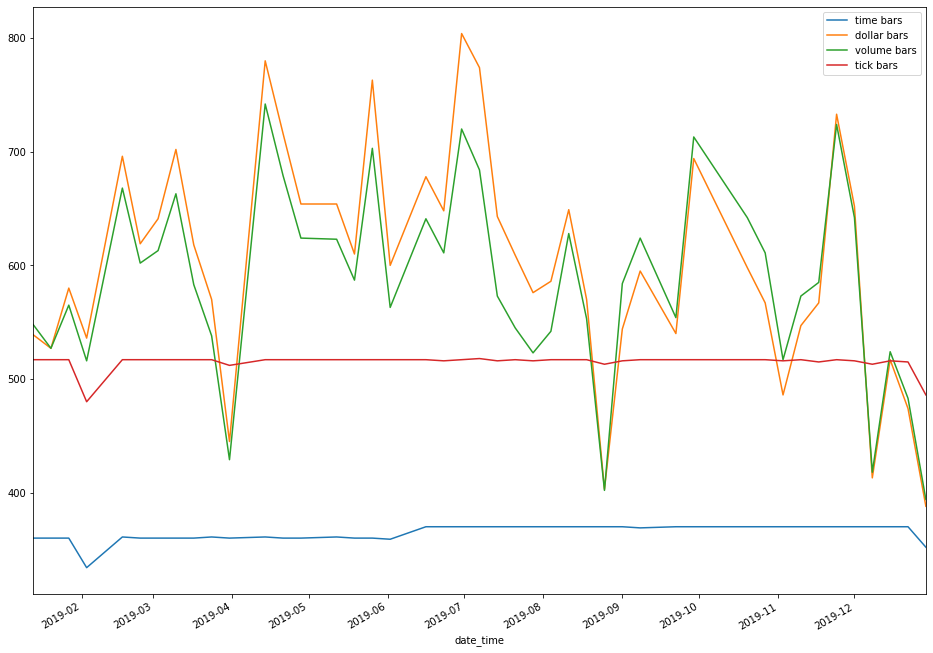

In [19]:
filterd_idx = time_count.index[time_count>300]

plt.figure(figsize=(16,12))

time_count[filterd_idx].plot(label='time bars')
dollar_count[filterd_idx].plot(label='dollar bars')
volume_count[filterd_idx].plot(label='volume bars')
tick_count[filterd_idx].plot(label='tick bars')

plt.legend()
plt.show()

从图中可以看出，Volume Bars 比 Dollar Bars 的周数量稍微稳定一些

As you can see from the figure, the value of Volume Bars is a little more stable than Dollar Bars

### 收益是否符合正态分布  (Partial Return to Normality)

#### qq plot test

In [20]:
time_returns = np.log(time_bars['close'].dropna()).diff().dropna()
tick_returns = np.log(tick_bars['close']).diff().dropna()
volume_returns = np.log(volume_bars['close']).diff().dropna()
dollar_returns = np.log(dollar_bars['close']).diff().dropna()

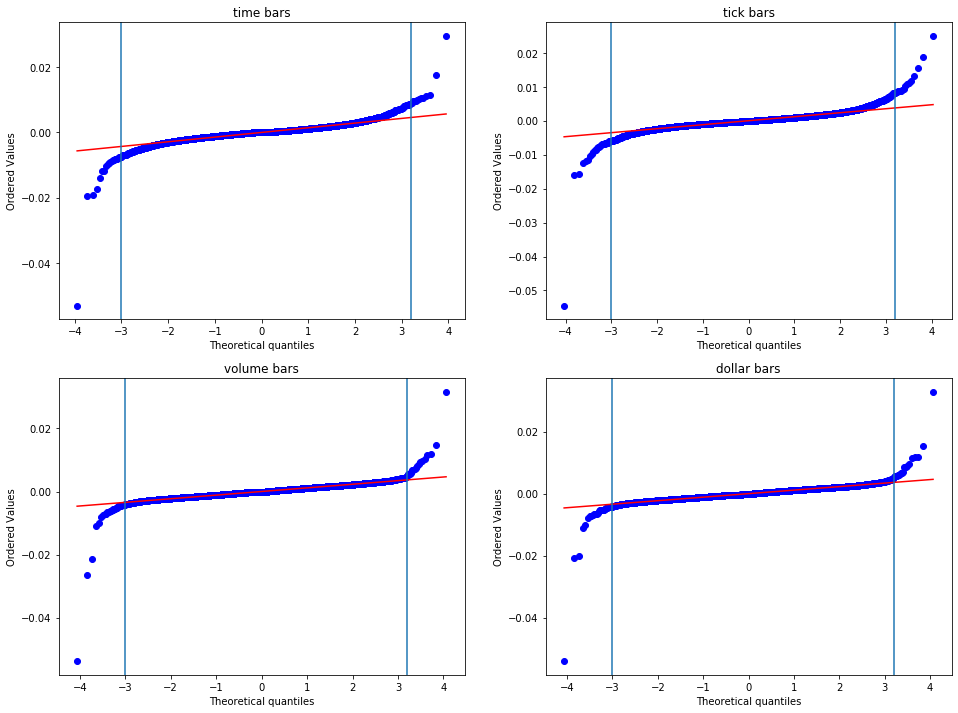

In [21]:
plt.figure(figsize=(16,12))
plt.subplot(221)
stats.probplot(time_returns, plot=plt)
plt.axvline(-3)
plt.axvline(3.2)
plt.title("time bars")
plt.subplot(222)
stats.probplot(tick_returns, plot=plt)
plt.axvline(-3)
plt.axvline(3.2)
plt.title("tick bars")
plt.subplot(223)
stats.probplot(volume_returns, plot=plt)
plt.axvline(-3)
plt.axvline(3.2)
plt.title("volume bars")
plt.subplot(224)
stats.probplot(dollar_returns, plot=plt)
plt.axvline(-3)
plt.axvline(3.2)
plt.title("dollar bars")
plt.show()

#### 测试平稳性 (Stationary Test)

In [22]:
time_bar_adf_result = ts.adfuller(time_returns, maxlag=int(pow(len(time_returns)-1,(1/3))), regression='ct', autolag=None)
result
tick_bar_adf_result = ts.adfuller(tick_returns, maxlag=int(pow(len(time_returns)-1,(1/3))), regression='ct', autolag=None)
result
volume_bar_adf_result = ts.adfuller(volume_returns, maxlag=int(pow(len(time_returns)-1,(1/3))), regression='ct', autolag=None)
result
dollar_bar_adf_result = ts.adfuller(dollar_returns, maxlag=int(pow(len(time_returns)-1,(1/3))), regression='ct', autolag=None)
result

time_bar_adf_result, tick_bar_adf_result, volume_bar_adf_result, dollar_bar_adf_result

((-25.344689455461953,
  0.0,
  26,
  17625,
  {'1%': -3.959283742602442,
   '5%': -3.4107391298057825,
   '10%': -3.127196713348487}),
 (-29.358838864386904,
  0.0,
  26,
  24887,
  {'1%': -3.9591338141399013,
   '5%': -3.410666427980648,
   '10%': -3.1271538999376784}),
 (-31.731196017904225,
  0.0,
  26,
  28051,
  {'1%': -3.959092773291872,
   '5%': -3.4106465264049484,
   '10%': -3.1271421799562282}),
 (-32.560504081726464,
  0.0,
  26,
  28754,
  {'1%': -3.959084881019152,
   '5%': -3.4106426992525147,
   '10%': -3.1271399261504422}))

#### 测试自相关性 (Autocorrelation Test)

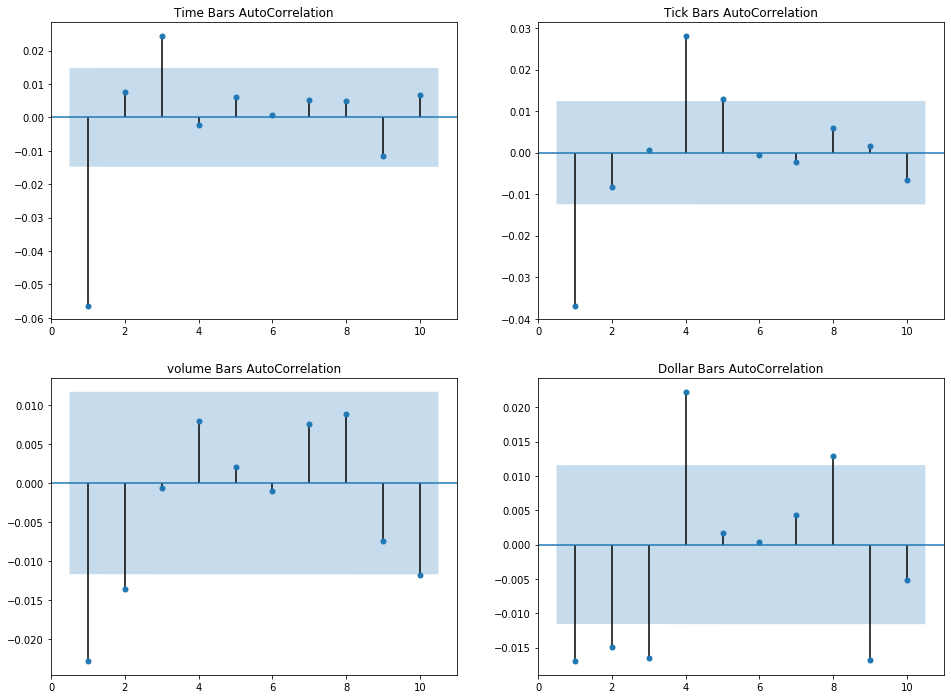

In [23]:
plt.figure(figsize=(16,12))

ax1 = plt.subplot(221)
plot_acf(time_returns, lags=10, zero=False, ax=ax1)
plt.title('Time Bars AutoCorrelation')

ax2 = plt.subplot(222)
plot_acf(tick_returns, lags=10, zero=False, ax=ax2)
plt.title('Tick Bars AutoCorrelation')

ax3 = plt.subplot(223)
plot_acf(volume_returns, lags=10, zero=False, ax=ax3)
plt.title('volume Bars AutoCorrelation')

ax4 = plt.subplot(224)
plot_acf(dollar_returns, lags=10, zero=False, ax=ax4)
plt.title('Dollar Bars AutoCorrelation')

plt.show()

#### 密度图观测  (density plot test)

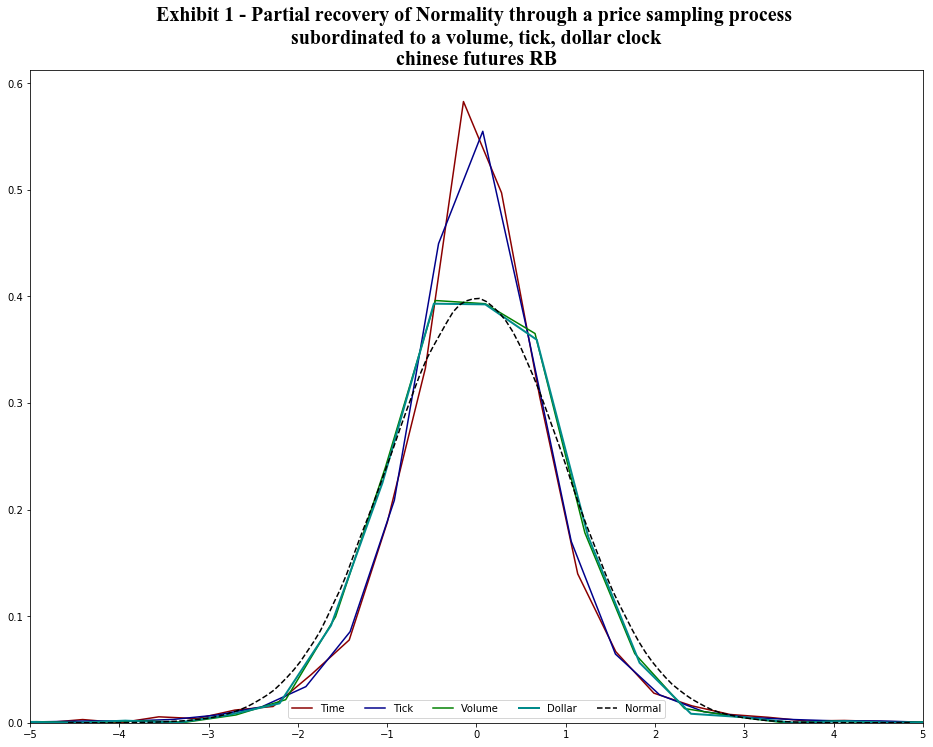

In [24]:
# Calculate the differences
time_diff = time_returns
tick_diff = tick_returns
volume_diff = volume_returns
dollar_diff = dollar_returns

# Standardize the data
time_standard = (time_diff - time_diff.mean()) / time_diff.std()
tick_standard = (tick_diff - tick_diff.mean()) / tick_diff.std()
volume_standard = (volume_diff - volume_diff.mean()) / volume_diff.std()
dollar_standard = (dollar_diff - dollar_diff.mean()) / dollar_diff.std()

# Plot the Distributions
plt.figure(figsize=(16,12))
sns.kdeplot(time_standard, label="Time", color='darkred')
sns.kdeplot(tick_standard, label="Tick", color='darkblue')
sns.kdeplot(volume_standard, label="Volume", color='green')
sns.kdeplot(dollar_standard, label="Dollar", linewidth=2, color='darkcyan')
sns.kdeplot(np.random.normal(size=1000000), label="Normal", color='black', linestyle="--")

plt.xticks(range(-5, 6))
plt.legend(loc=8, ncol=5)
plt.title('Exhibit 1 - Partial recovery of Normality through a price sampling process \nsubordinated to a volume, tick, dollar clock\nchinese futures RB',
          loc='center', fontsize=20, fontweight="bold", fontname="Times New Roman")
plt.xlim(-5, 5)
plt.show()

volume bars 和 dollar bars 非常类似，而且都很接近于标准正态分布。

但是请注意：我这里进行过价格区间调整，之前我用的数据期间有一次重大事件导致大幅低开，会导致偏离标准的正态分布。后来我去掉了这次重大事件，就回归到了标准正态分布。

*国内期货数据2020.01.01起采用单边统计
***
Volume bars are very similar to dollar bars, and they are very close to standard normal distributions.

But note: I've adjusted the price range here, and a major event during the previous data period with my data can cause a deviation from the standard normal distribution. Then I dropped this big event and returned to the standard normal distribution.

China Commodity Futures volume and dollar data from 2020.01.01 using unilateral statistics

---

## 结论 (Conclusion)

看到 Dollar Bars 和 Volume Bars 的密度图，我还是有点吃惊的，太接近于正态分布了，我之前找过一些分布去接近尖峰肥尾分布，现在看可以把思路反过来，用不同类型的Bar去接近正态分布。
***
I was a little surprised to see the density maps of Dollar Bars and Volume Bars, too close to the normal distribution. I've looked for some distributions to get close to the peak fattail distribution, and now I look at the way back, with different types of Bars to get close to normal distributions.

If you enjoyed this notebook then please be sure to star our repo!
* [mlfinlab](https://github.com/hudson-and-thames/mlfinlab)
* [research](https://github.com/hudson-and-thames/research)

---

## 我为什么喜欢这本书？(Why I like this book)

我之前也读过一些用机器学习预测收益的 **论文** 或者 **网站** 上的文章。

**论文** 的质量相对高一些，但是大部分都是解释一些机器学习的模型，用一些简单的特征，来预测第二天的收益率。但是这些论文的同质性很高，并没有什么独特的地方。有可能我没有找对地方，还希望大家指点。

有些 **网站** 上的文章甚至直接预测股价(非平稳时间序列)，然后直接把预测的股价和真实的股价放在一张图上，看起来真像是一台印钱机器画出来的图片，其实我们可以试一试直接用今天的股价来预测明天的股价，画一张图，那也会非常的惊喜。这些文章会让我感到非常的的气愤，因为他们只是为了博取观众的眼球，而做的一些虚假的研究。

在看本书之前我自己曾经和一朋友还讨论过一件事，就是如果我每个时间点都能预测准的话，那我岂不是可以统治世界了吗？这是一个件不科学的事情。当我看到本书的 2.5 Sampling Features 时，里面提到在一个随机的时间点预测下个5%是涨还是跌是很难的，但是如果在特定的条件下可能会大大提高准确率。我突然感觉到这个问题也是大家正在研究的。

我现在才看完 part1，我觉得作者是真正的在研究ML预测收益中的实际问题，而不只是为了出版。当然能出版的都是比较浅的，我们要应用可能需要更深一步的挖掘。

虽然本书面向的读者需要比较多的前置知识和一些实践经验，但是我尽量说的详细一些，能让初学者快速读懂。
***
I've read some papers or articles on the website that use machine learning to predict stock return.

The paper is relatively high quality, but most of then just explains some machine learning model, and using some simple features to predict the next day's return. The homogeneity of these papers is high, and there is nothing unique. It is possible that I did not find the right place to read paper, but also hope that you point out.

Some articles on the website even directly predict the stock price (non-stationary time series). And then directly plot the predicted stock price and the real stock price on one chart, it looks really like a money machine. 

In fact, we can try directly with today's stock price to predict tomorrow's stock price, draw a picture, it will be very pleasant. These articles will make me very angry, because they are just to get the audience's attention.

Before I read this book, I had discussed one thing with a friend, that is, if I could predict at every time point, wouldn't I rule the world? This is an unscientific thing. When I read the **2.5 Sampling Features** in this book, it says *"it's hard to predict whether the next 5% will go up or down at a random point in time, but it might greatly improve accuracy under certain conditions."* I suddenly felt that the problem was also being studied by others.

I'm just reading part1 now, and I think the author is really a real problem in studying ML's predictive earnings, not just for publication. Of course the content can be published are relatively simple, we want to apply may need a deeper excavation.

Although the book is intended for readers to require more pre-knowledge and some practical experience, but I try to say a little more detail, so that beginners can read quickly.